# NYC Yellow Taxi Growth

#### The objectives of this program:
Using the data set that comes from NYC open data of **NYC Yellow Taxi Service** and **Uber Taxi Service** we would like to **analyze the growth** of the NYC Yellow Taxi Service by using the amount of pickups done daily.

We will be using correlation between taxi and uber in respective borough to observe the **correlation between the growth rate** of both taxi and uber to help understand how competition impacts pickup amounts. We will also use statistics to help **predict the growth** done within the next few days. We will be using **histograms and line charts** to demonstrate the growth.

In [1]:
sc

In [2]:
# imports
import csv
import pandas as pd
import numpy as np
import scipy
import datetime
import fiona
import pyproj
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point

## Taxi vs Uber

The textFile below imports the actual data but the one after is clean data that was ran from hadoop.  
The run time took around 1 hour and 30 minutes for 10 executers and 5 executer cores.

In [3]:
###### Run only if you want to do ingestion
# taxi_aug14 = sc.textFile('../yellow_tripdata_2014-08.csv', use_unicode=False).filter(lambda x: x != "").cache()
# uber_aug14 = sc.textFile('../uber-raw-data-aug14.csv', use_unicode=False).cache()
# boro_shape = fiona.open('../nyu_2451_34490/nyu_2451_34490.shp')

In [4]:
import ast
trdd = sc.textFile('taxi_data.txt', use_unicode=False).filter(lambda x: x != "").map(lambda x: ast.literal_eval(x)).cache()
urdd = sc.textFile('uber_data.txt', use_unicode=False).filter(lambda x: x != "").map(lambda x: ast.literal_eval(x)).cache()
boro_shape = fiona.open('../nyu_2451_34490/nyu_2451_34490.shp')

### Borough Estimation

We will be using pyproj to get the a coordinate (lon, lat) and project it to a map with (x,y) coordinates. We want to be able to import coodinates and find the borough, given our shapes.

In [5]:
lboro = ['Bronx', 'Brooklyn','Manhattan', 'Queens', 'Staten Island']
boro_range = [[],[],[],[],[]]
for i in range(5):
    boro_range[i] = shape(boro_shape[i]['geometry'])
def getlocation(x):
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    gLoc = Point(proj(float(x[0]) , float(x[1])))
    for i in range(len(boro_range)):
        if(gLoc.within(boro_range[i])):
            return lboro[i]

### Data Ingestion for August 2014 Taxi Data

We will clean the data into:  
```((boro, pickup, 1)```  
Then we will group this data as:  
```[boro [(date, count)]]```

In [6]:
##### trdd is already made above from NYU hdfs cluster

# def extractTaxi(partId, records):
#     if partId==0:
#         records.next()
#     reader = csv.reader(records)
#     for row in reader:
#         (pickup, boro) = (row[1].split(" ")[0], getlocation((row[5],row[6])))
#         if boro in ['Bronx', 'Brooklyn','Manhattan', 'Queens', 'Staten Island']:
#             yield ((boro, pickup) , 1)
# trdd = taxi_aug14.mapPartitionsWithIndex(extractTaxi)\
#                 .reduceByKey(lambda x, y: x+y)\
#                 .sortBy(lambda x:(x[0][0], x[0][1]))\
#                 .map(lambda x: (x[0][0], [(x[0][1], x[1])]))\
#                 .reduceByKey(lambda x, y: (x+y)) \
#                 .sortBy(lambda x:(x[0]))
#trdd.take(10)

### Data Ingestion for August 2014 Uber Data

Just like the taxi data, we will format the Uber data just the same.

In [7]:
##### urdd is already made above from NYU hdfs cluster

# def extractUber(partId, records):
#     if partId==0:
#         records.next()
#     reader = csv.reader(records)
#     for row in reader:
#         (pickup, boro) = (row[0].split(" ")[0],  getlocation((row[2],row[1])))
#         if boro in ['Bronx', 'Brooklyn', 'Queens', 'Manhattan', 'Staten Island']:
#             yield ((boro, pickup) , 1)
# 
# urdd = uber_aug14.mapPartitionsWithIndex(extractUber)\
#                 .reduceByKey(lambda x, y: x+y)\
#                 .map(lambda x: ((x[0][0], datetime.datetime.strptime(x[0][1], "%m/%d/%Y").strftime("%Y-%m-%d")), x[1]))\
#                 .sortBy(lambda x:(x[0][0], x[0][1]))\
#                 .map(lambda x: (x[0][0], [(x[0][1], x[1])]))\
#                 .reduceByKey(lambda x, y: (x+y)) \
#                 .sortBy(lambda x:(x[0]))
#urdd.take(10)

##### This function will get data from either of the dataset

In [8]:
# gets data given a key
def get_data(data, i):
    # returns ALL values
    if i == -1:
        return data.values().map(lambda x: list(zip(*x)[1])).collect()
    # returns ALL dates
    if i == -2:
        return data.values().map(lambda x: zip(*x)[0]).collect()
    # returns all days
    if i == -3:
        return data.values().map(lambda x: zip(*x)[0]) \
            .map(lambda dates : map(lambda date: int(datetime.datetime.strptime(date, "%Y-%m-%d").strftime("%d")), dates)).collect()
    return list(data.values().zipWithIndex().filter(lambda (key,index) : index == i).map(lambda x: zip(*x[0])[1]).collect()[0])
# don't use index 2 in the actual database because it is 'outside_nyc'
lboro = urdd.map(lambda x: x[0]).collect()
nboro = len(trdd.map(lambda x: x[0]).collect())

### Scatter Line Graph for Taxi vs Uber

We want to first normalize our data as we obviously know that the Yellow New York Taxi has a sample size greater than Uber. We do this by dividing each frequency by the total accumilation of frequencies.  
We also want to do a bar shift to make a bar graph side by side.

In [37]:
def normalize(data):
    total = float(sum(map(abs,data)))
    if total:
        return [y / total for y in data]
    return data

def bar_shift(data):
    return [x+.3 for x in data]

def make_bar(tx, ty, ux, uy, title):
    plt.bar(tx, ty, width=0.3, color='b', label='taxi')
    plt.bar(ux, uy, width=0.3, color='r', label='uber')
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('days')
    plt.ylabel('pickups ratio')
    plt.tight_layout()
    plt.show()

#### We will first make a scatter to observe the data

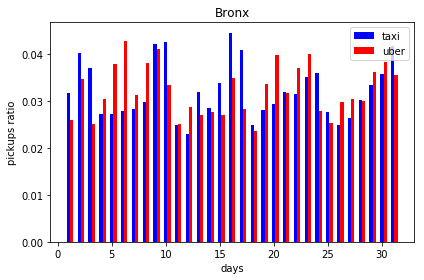

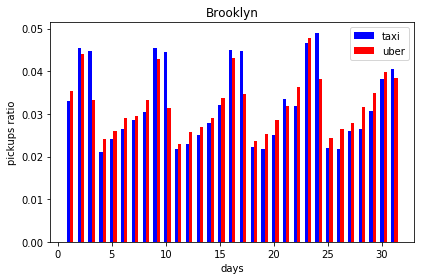

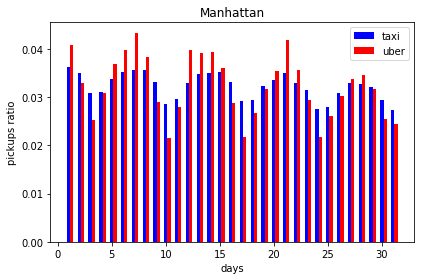

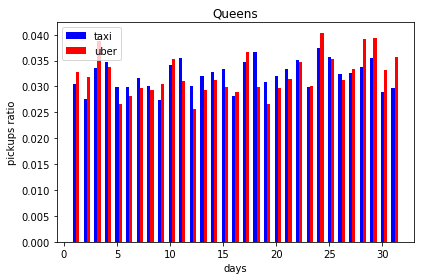

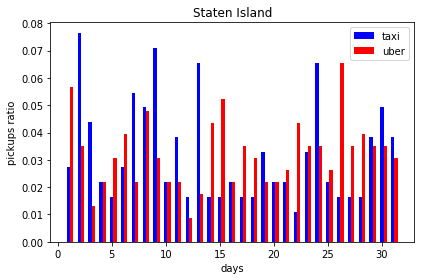

In [10]:
for i in range(nboro):
    make_bar(get_data(trdd, -3)[i], normalize(get_data(trdd, i)),
             bar_shift(get_data(urdd, -3)[i]), normalize(get_data(urdd, i)), lboro[i])

#### Obsevation

After normalizing, we see that both data show stricking resemblence in respect to borough and day of the week. However we are still not able to tell much about the graph besides the fact that both data set follows a similar ratio, but the uber data fluctuates the most.

### Cumilative Line Graph for Taxi vs Uber

In [11]:
def get_vb(key):
    # evaluate the histogram
    tvb = list(np.histogram(normalize(get_data(trdd, key)), bins=31))
    uvb = list(np.histogram(normalize(get_data(urdd, key)), bins=31))
   
    #evaluate the cumulative
    tvb[0] = np.cumsum(tvb[0])
    uvb[0] = np.cumsum(uvb[0])
    
    return tvb, uvb

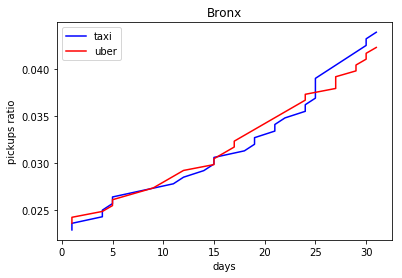

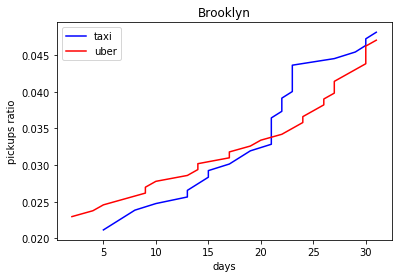

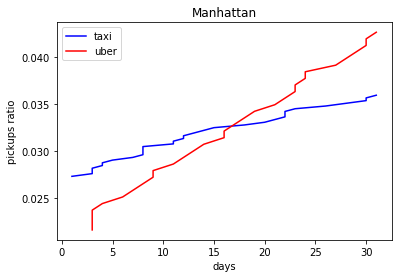

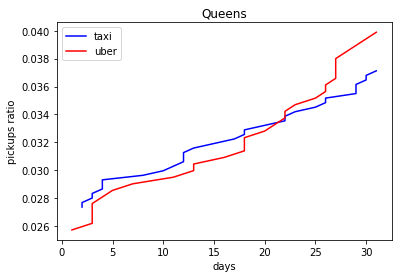

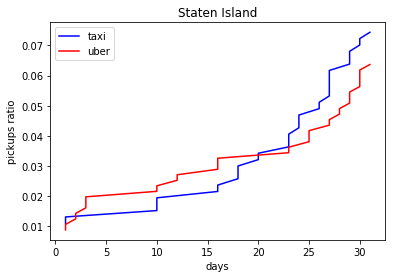

In [12]:
# plot the cumulative functions
def make_accum_graph(tvb, uvb, key):
        plt.plot(tvb[0], tvb[1][:-1], c='blue', label = 'taxi')
        plt.plot(uvb[0], uvb[1][:-1], c='red', label = 'uber')
        plt.title(lboro[key])
        plt.legend(loc='best')
        plt.xlabel('days')
        plt.ylabel('pickups ratio')
        plt.show()
    
for i in range(nboro):
    tvb, uvb = get_vb(i)
    make_accum_graph(tvb, uvb, i)

#### Obsevation

After normalizing, we see that in Manhattan and Queens we see that Uber has been steadily increasing. However, the taxi service was overall had the most increase.

## Growth Rate Comparison

Then we will make growth rate comparison using histograph of boro based in seperate squares to get a better idea of increase and decrease correlation for both statistics.

In [17]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
sqlc = SQLContext(sc)

In [31]:
def get_growth(data, key):
    data = sc.parallelize(data.collect()[key][1])
    df = sqlc.createDataFrame(data, ["date", "value"])
    my_window = Window.partitionBy().orderBy("date")

    df = df.withColumn("prev_value", F.lag(df.value).over(my_window))
    df = df.withColumn("diff", F.when(F.isnull(((df.value - df.prev_value)/df.prev_value)*100), 0)
                                  .otherwise((df.value - df.prev_value)/df.prev_value)*100)
    return df.rdd.map(lambda x: x.date.encode("utf-8")).collect(), df.rdd.map(lambda x: x.diff).collect()

In [32]:
def make_growth_chart(tx, ty, ux, uy, title):
    plt.plot(tx, ty,'-o', c ='blue', label = 'taxi')
    plt.plot(ux, uy, '-o', c='red', label = 'uber')
    plt.axhline(linewidth=3, ls = 'dashed')
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('days')
    plt.ylabel('pickups ratio')
    plt.show()

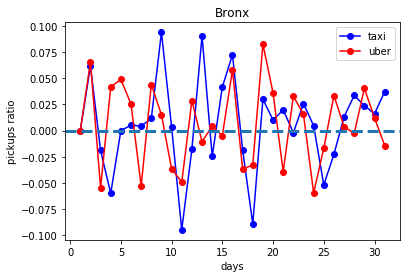

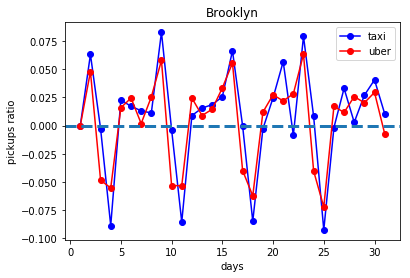

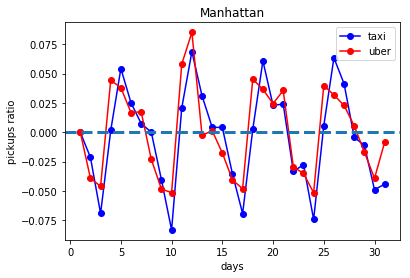

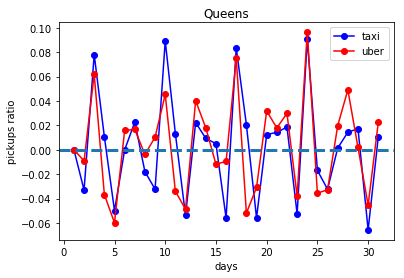

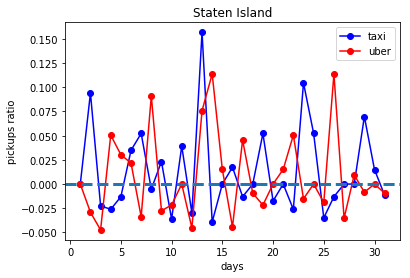

In [43]:
tlaccum = []
ulaccum = []
for i in range(nboro):
    tgrowth = normalize(get_growth(trdd, i)[1])
    ugrowth = normalize(get_growth(urdd, i)[1])
    make_growth_chart(get_data(trdd, -3)[i], tgrowth, get_data(urdd, -3)[i], ugrowth, lboro[i])
    tlaccum.append(sum(tgrowth))
    ulaccum.append(sum(ugrowth))

#### Obsevation

After normalizing, we see that both data generally peak at similar day of the week. However not much can be said about this graph.

In [111]:
def growth_bar(x, ty, uy, title):
    plt.bar(x, ty, color='b')
    plt.bar(x, uy, color='r')
    y = (ty[0] if ty[0] > 0 else .003)
    plt.text(-.25, y, str(ty[0]))
    y = (uy[1] if uy[1] > 0 else .003)
    plt.text(.75, y, str(uy[1]))
    plt.axhline(linewidth=3, ls = 'dashed')
    plt.title(title)
    plt.xticks(x, ['taxi','uber'])
    plt.xlabel('services')
    plt.ylabel('net pickups ratio')
    plt.tight_layout()
    plt.show()

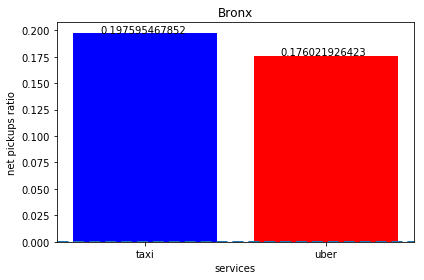

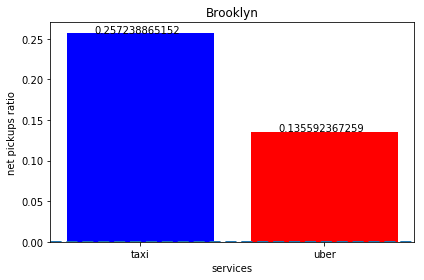

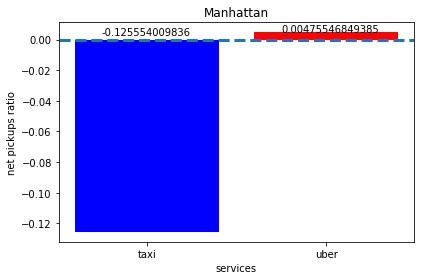

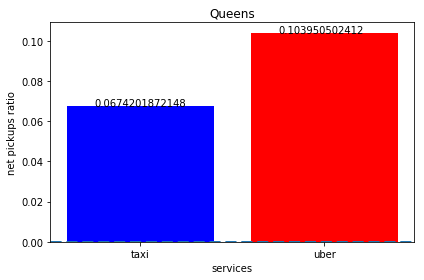

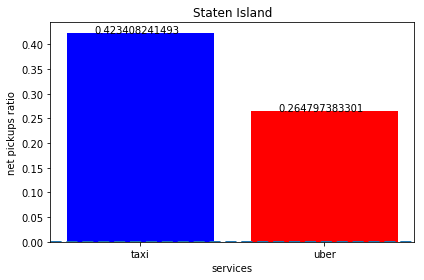

In [112]:
for i in range(nboro):
    growth_bar([0, 1], [tlaccum[i], 0], [0,ulaccum[i]], lboro[i])

#### Observation

Here we see the overall accumulation of the data throughtout the month. We can see how in Manhattan the net growth in service has decreased for Manhattan unlike Uber. However, for everything else it seems that Manhattan has gained the most service increase.

### Coefficient Correlation

In [100]:
def make_coeff(slope, intercept, x, y, key):
    plt.plot(x, y, 'o', label = 'taxi/uber')
    plt.plot(x, intercept+ slope*x, '-', label = 'correlation' )
    plt.title(lboro[key])
    plt.legend(loc='best')
    plt.xlabel('uber')
    plt.ylabel('taxi')
    plt.show()

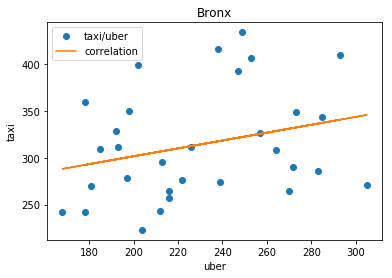

r-value:  0.2771697761573398
p-value:  0.131157843558119


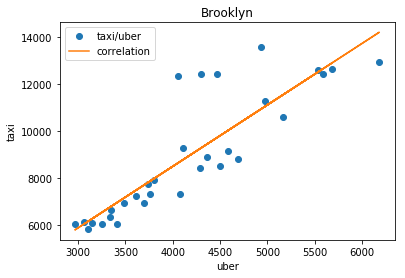

r-value:  0.8659455960466571
p-value:  3.151783693885222e-10


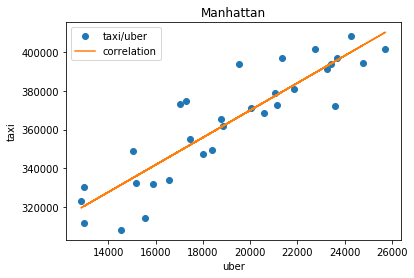

r-value:  0.8977182987742911
p-value:  7.70855370093029e-12


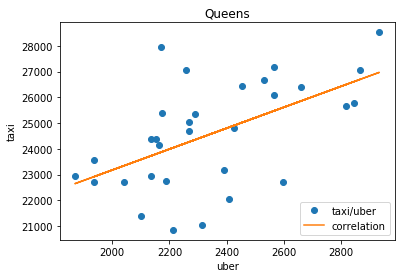

r-value:  0.5556554572957314
p-value:  0.0011737976156903551


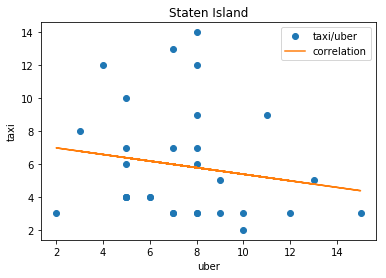

r-value:  -0.16901524909885174
p-value:  0.36338756290387453


In [29]:
from scipy import stats
import numpy as np

for i in range(nboro):
    x = scipy.array(get_data(urdd, i))
    y = scipy.array(get_data(trdd, i))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    make_coeff(slope, intercept, x, y, i)
    print 'r-value: ', r_value
    print 'p-value: ', p_value

### Observation

In here we see the overall corellation between the Yellow and Uber Taxi service. Unlike Staten Island which had a negative trend, although we can reject this as it gives a high p-value, we see how other values that show a positive correlation gave a low p-score. Althogh they do share a correlation, it wasn't negative as we hypothesized.

## Prediction

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

In [24]:
columns = ['boro', 'days_in_month', 'number_of_pickup']
dic_boro = {'bronx': 0, 'brooklyn': 1, 'manhattan': 2,  'queens': 3, 'staten': 4}

In [25]:
Urdd_table = uber_aug14.mapPartitionsWithIndex(extractUber)\
                .reduceByKey(lambda x, y: x+y)\
                .map(lambda x: ((x[0][0], datetime.datetime.strptime(x[0][1], "%m/%d/%Y").strftime("%Y-%m-%d")), x[1]))\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (dic_boro[x[0][0]], int(datetime.datetime.strptime(x[0][1], "%Y-%m-%d").strftime("%d")),x[1]))
                               # (x[1]-min_boro[dic_boro[x[0][0]]])/(max_boro[dic_boro[x[0][0]]]- min_boro[dic_boro[x[0][0]]])))

NameError: name 'internet_on' is not defined

In [ ]:
df_urdd = Urdd_table.collect()
'''df = pd.DataFrame(Urdd_table.collect(), columns=columns)
df_boro = [[],[],[],[],[],[]]
for i in range(6):
    for j in range(len(df)):
        if df['boro'][j] == i:
            df_boro[i].append(df.loc[j].values)
'''


In [ ]:
df_boro = [[],[],[],[],[],[]]
for i in range(nboro):
    for item in df_urdd:
        if item[0] == i:
            df_boro[i].append(item)
for i in range(6):
    df_boro[i] = pd.DataFrame(df_boro[i], columns=columns)

In [ ]:
X = [[],[],[],[],[],[]]
y =[[],[],[],[],[],[]]
X_train=[[],[],[],[],[],[]]
X_test=[[],[],[],[],[],[]]
y_train=[[],[],[],[],[],[]] 
y_test=[[],[],[],[],[],[]]

for i in range(nboro):
    X[i] = df_boro[i][['boro', 'days_in_month']].values
    y[i] = df_boro[i][['number_of_pickup']].values
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], test_size=0.4, random_state=1)
    print(X_train[i].shape, X_test[i].shape)

### Training each prediction

In [ ]:
linear_r = LinearRegression()
lasso_r = Lasso()
ridge_r = Ridge(alpha=1.0)
elastic_r = ElasticNet(alpha=1, l1_ratio=0.5)

In [ ]:
for i in range(nboro):
    linear_r.fit(X_train[i], y_train[i])
    lasso_r.fit(X_train[i], y_train[i])
    ridge_r.fit(X_train[i], y_train[i])
    elastic_r.fit(X_train[i], y_train[i])
    print(lboro(i), lasso_r.predict(df_boro[i][['boro', 'days_in_month']].values))